In [1]:
import os

from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras import backend as K
from keras.models import load_model
from math import ceil
import numpy as np
from matplotlib import pyplot as plt

from ssd_model import build_model
from ssd_loss import SSDLoss
from ssd_box_encode_decode_utils import SSDBoxEncoder, decode_y, decode_y2
from generator import BatchGenerator

%matplotlib inline
plt.rcParams['figure.figsize'] = (8, 8)
plt.rcParams['image.interpolation'] = 'nearest'

%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


In [2]:
img_height = 300 # Height of the input images
img_width = 480 # Width of the input images
img_channels = 3 # Number of color channels of the input images
n_classes = 6 # Number of classes including the background class
min_scale = 0.08 # The scaling factor for the smallest anchor boxes
max_scale = 0.96 # The scaling factor for the largest anchor boxes
scales = [0.08, 0.16, 0.32, 0.64, 0.96] # An explicit list of anchor box scaling factors. If this is passed, it will override `min_scale` and `max_scale`.
aspect_ratios = [0.5, 1.0, 2.0] # The list of aspect ratios for the anchor boxes
two_boxes_for_ar1 = True # Whether or not you want to generate two anchor boxes for aspect ratio 1
limit_boxes = False # Whether or not you want to limit the anchor boxes to lie entirely within the image boundaries
variances = [1.0, 1.0, 1.0, 1.0] # The list of variances by which the encoded target coordinates are scaled
coords = 'centroids' # Whether the box coordinates to be used should be in the 'centroids' or 'minmax' format, see documentation
normalize_coords = False # Whether or not the model is supposed to use relative coordinates that are within [0,1]

K.clear_session() # Clear previous models from memory.
model, predictor_sizes = build_model(image_size=(img_height, img_width, img_channels),
                                      n_classes=n_classes,
                                      min_scale=min_scale,
                                      max_scale=max_scale,
                                      scales=scales,
                                      aspect_ratios_global=aspect_ratios,
                                      aspect_ratios_per_layer=None,
                                      two_boxes_for_ar1=two_boxes_for_ar1,
                                      limit_boxes=limit_boxes,
                                      variances=variances,
                                      coords=coords,
                                      normalize_coords=normalize_coords)

In [3]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 300, 480, 3)   0                                            
____________________________________________________________________________________________________
input_norm (Lambda)              (None, 300, 480, 3)   0           input_1[0][0]                    
____________________________________________________________________________________________________
conv1 (Conv2D)                   (None, 300, 480, 32)  2432        input_norm[0][0]                 
____________________________________________________________________________________________________
bn1 (BatchNormalization)         (None, 300, 480, 32)  128         conv1[0][0]                      
___________________________________________________________________________________________

In [4]:
### split dataset
def split_csv(file_path, train_val_ratio = 0.8):
    csvfile = open(file_path, 'r').readlines()
    dir_name = os.path.dirname(file_path)
    train_name = os.path.join(dir_name, 'train_labels.csv')
    val_name = os.path.join(dir_name, 'val_labels.csv')
    file_len = len(csvfile)
    train_len = int(train_val_ratio * file_len)
    open(train_name, 'w+').writelines(csvfile[0:train_len])
    open(val_name, 'w+').writelines(csvfile[train_len:])

split_csv('./data/udacity_driving_datasets/labels.csv')

In [7]:
### Set up training
batch_size = 16

# 3: Instantiate an Adam optimizer and the SSD loss function and compile the model
adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=5e-05)
ssd_loss = SSDLoss(neg_pos_ratio=3, n_neg_min=0, alpha=1.0)
model.compile(optimizer=adam, loss=ssd_loss.compute_loss)

In [8]:
# 4: Instantiate an encoder that can encode ground truth labels into the format needed by the SSD loss function 

ssd_box_encoder = SSDBoxEncoder(img_height=img_height,
                                img_width=img_width,
                                n_classes=n_classes, 
                                predictor_sizes=predictor_sizes,
                                min_scale=min_scale,
                                max_scale=max_scale,
                                scales=scales,
                                aspect_ratios_global=aspect_ratios,
                                aspect_ratios_per_layer=None,
                                two_boxes_for_ar1=two_boxes_for_ar1,
                                limit_boxes=limit_boxes,
                                variances=variances,
                                pos_iou_threshold=0.5,
                                neg_iou_threshold=0.2,
                                coords=coords,
                                normalize_coords=normalize_coords)

# 5: Create the training set batch generator

train_dataset = BatchGenerator(images_path='./data/udacity_driving_datasets/',
                               include_classes='all',
                               box_output_format=['class_id', 'xmin', 'xmax', 'ymin', 'ymax']) # This is the format in which the generator is supposed to output the labels. At the moment it **must** be the format set here.

train_dataset.parse_csv(labels_path='./data/udacity_driving_datasets/train_labels.csv',
                        input_format=['image_name', 'xmin', 'xmax', 'ymin', 'ymax', 'class_id']) # This is the order of the first six columns in the CSV file that contains the labels for your dataset. If your labels are in XML format, maybe the XML parser will be helpful, check the documentation.

# Change the online data augmentation settings as you like
train_generator = train_dataset.generate(batch_size=batch_size,
                                         train=True,
                                         ssd_box_encoder=ssd_box_encoder,
                                         equalize=False,
                                         brightness=(0.5, 2, 0.5), # Randomly change brightness between 0.5 and 2 with probability 0.5
                                         flip=0.5, # Randomly flip horizontally with probability 0.5
                                         translate=((5, 50), (3, 30), 0.5), # Randomly translate by 5-50 pixels horizontally and 3-30 pixels vertically with probability 0.5
                                         scale=(0.75, 1.3, 0.5), # Randomly scale between 0.75 and 1.3 with probability 0.5
                                         random_crop=False,
                                         crop=False,
                                         resize=False,
                                         gray=False,
                                         limit_boxes=True,
                                         include_thresh=0.4,
                                         diagnostics=False)

n_train_samples = train_dataset.get_n_samples()

# 6: Create the validation set batch generator (if you want to use a validation dataset)

val_dataset = BatchGenerator(images_path='./data/udacity_driving_datasets/',
                             include_classes='all',
                             box_output_format=['class_id', 'xmin', 'xmax', 'ymin', 'ymax'])

val_dataset.parse_csv(labels_path='./data/udacity_driving_datasets/val_labels.csv',
                      input_format=['image_name', 'xmin', 'xmax', 'ymin', 'ymax', 'class_id'])

val_generator = val_dataset.generate(batch_size=batch_size,
                                     train=True,
                                     ssd_box_encoder=ssd_box_encoder,
                                     equalize=False,
                                     brightness=False,
                                     flip=False,
                                     translate=False,
                                     scale=False,
                                     random_crop=False,
                                     crop=False,
                                     resize=False,
                                     gray=False,
                                     limit_boxes=True,
                                     include_thresh=0.4,
                                     diagnostics=False)

n_val_samples = val_dataset.get_n_samples()

In [8]:
### Run training
# 6: Run training
epochs = 10

history = model.fit_generator(generator = train_generator,
                              steps_per_epoch = ceil(n_train_samples/batch_size),
                              epochs = epochs,
                              callbacks = [ModelCheckpoint('./ssd7_0_weights_epoch{epoch:02d}_loss{loss:.4f}.h5',
                                                           monitor='val_loss',
                                                           verbose=1,
                                                           save_best_only=True,
                                                           save_weights_only=True,
                                                           mode='auto',
                                                           period=1),
                                           EarlyStopping(monitor='val_loss',
                                                         min_delta=0.001,
                                                         patience=2),
                                           ReduceLROnPlateau(monitor='val_loss',
                                                             factor=0.5,
                                                             patience=0,
                                                             epsilon=0.001,
                                                             cooldown=0)],
                              validation_data = val_generator,
                              validation_steps = ceil(n_val_samples/batch_size))

model_name = 'ssd7_0'
model.save('./{}.h5'.format(model_name))
model.save_weights('./{}_weights.h5'.format(model_name))

print()
print("Model saved as {}.h5".format(model_name))
print("Weights also saved separately as {}_weights.h5".format(model_name))
print()

Epoch 1/10
1145/1145 [==============================] - 472s - loss: 0.1965 - val_loss: 0.1802
Epoch 2/10
1145/1145 [==============================] - 420s - loss: 0.1528 - val_loss: 0.1775
Epoch 3/10
1145/1145 [==============================] - 420s - loss: 0.1390 - val_loss: 0.1646
Epoch 4/10
1145/1145 [==============================] - 421s - loss: 0.1310 - val_loss: 0.1279
Epoch 5/10
1145/1145 [==============================] - 422s - loss: 0.1251 - val_loss: 0.1290
Epoch 6/10
1145/1145 [==============================] - 423s - loss: 0.1174 - val_loss: 0.1170
Epoch 7/10
1145/1145 [==============================] - 423s - loss: 0.1150 - val_loss: 0.1245
Epoch 8/10
1145/1145 [==============================] - 423s - loss: 0.1115 - val_loss: 0.1136
Epoch 9/10
1145/1145 [==============================] - 423s - loss: 0.1104 - val_loss: 0.1110
Epoch 10/10
1145/1145 [==============================] - 423s - loss: 0.1092 - val_loss: 0.1140

Model saved as ssd7_0.h5
Weights also saved sepa

In [9]:
model.load_weights('./ssd7_0_weights.h5')

In [10]:
### Make predictions

# 1: Set the generator
predict_generator = val_dataset.generate(batch_size=1,
                                         train=False,
                                         equalize=False,
                                         brightness=False,
                                         flip=False,
                                         translate=False,
                                         scale=False,
                                         random_crop=False,
                                         crop=False,
                                         resize=False,
                                         gray=False,
                                         limit_boxes=True,
                                         include_thresh=0.4,
                                         diagnostics=False)

In [11]:
# 2: Generate samples
X, y_true, filenames = next(predict_generator)

i = 0 # Which batch item to look at

print("Image:", filenames[i])
print()
print("Ground truth boxes:\n")
print(y_true[i])

Image: 1479504393373167326.jpg

Ground truth boxes:

[[  1  30  77 139 166]
 [  1  87 118 143 160]
 [  1 131 154 140 157]
 [  1 172 181 143 152]
 [  1 186 193 144 151]
 [  1 248 255 143 150]
 [  1 267 276 141 150]
 [  1 271 282 143 152]
 [  1 334 348 143 150]
 [  1 363 402 134 148]]


In [12]:
# 3: Make a prediction
y_pred = model.predict(X)

In [13]:
# 4: Decode the raw prediction `y_pred`
y_pred_decoded = decode_y2(y_pred,
                           confidence_thresh=0.5,
                          iou_threshold=0.4,
                          top_k='all',
                          input_coords='centroids',
                          normalize_coords=False,
                          img_height=None,
                          img_width=None)

print("Decoded predictions (output format is [class_id, confidence, xmin, xmax, ymin, ymax]):\n")
print(y_pred_decoded[i])

Decoded predictions (output format is [class_id, confidence, xmin, xmax, ymin, ymax]):

[[   1.            0.99762589   78.20475006  115.56859589  140.83630371
   161.64242554]
 [   1.            0.98563784   34.52700806   75.3028717   138.40696716
   165.21577454]
 [   1.            0.85228759   21.21943092   58.31216431  141.03118896
   167.61175537]
 [   1.            0.78128773  129.17750549  148.9679718   139.95672607
   157.04647827]
 [   1.            0.60908037   56.73487473   80.96183777  137.84764099
   164.06510925]]


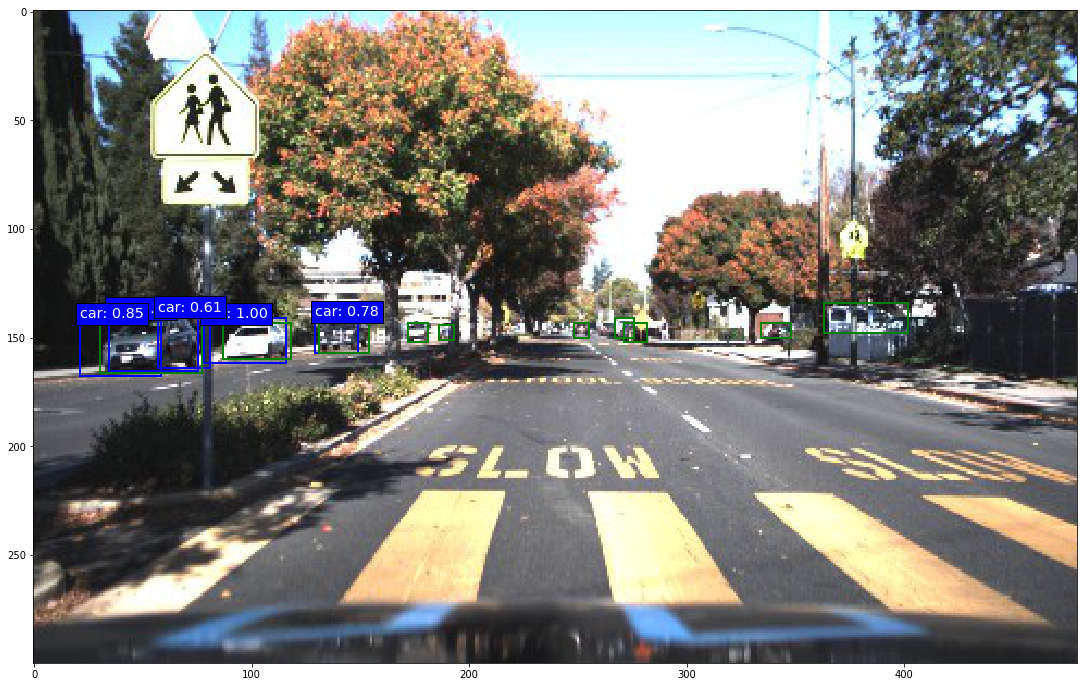

In [14]:
# 5: Draw the predicted boxes onto the image
plt.figure(figsize=(20,12))
plt.imshow(X[i])

current_axis = plt.gca()

classes = ['background', 'car', 'truck', 'pedestrian', 'bicyclist', 'light'] # Just so we can print class names onto the image instead of IDs

# Draw the predicted boxes in blue
for box in y_pred_decoded[i]:
    label = '{}: {:.2f}'.format(classes[int(box[0])], box[1])
    current_axis.add_patch(plt.Rectangle((box[2], box[4]), box[3]-box[2], box[5]-box[4], color='blue', fill=False, linewidth=2))  
    current_axis.text(box[2], box[4], label, size='x-large', color='white', bbox={'facecolor':'blue', 'alpha':1.0})

# Draw the ground truth boxes in green (omit the label for more clarity)
for box in y_true[i]:
    label = '{}'.format(classes[int(box[0])])
    current_axis.add_patch(plt.Rectangle((box[1], box[3]), box[2]-box[1], box[4]-box[3], color='green', fill=False, linewidth=2))  
    #current_axis.text(box[1], box[3], label, size='x-large', color='white', bbox={'facecolor':'green', 'alpha':1.0})